# Evaluating basis functions of the Shim Loops

In [1]:
import argparse
import signal
import subprocess
import sys
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import time
from helpersFunctions import *
import ipywidgets as widgets
from IPython.display import display, clear_output

sys.path.append('..')

from shimTool.Tool import Tool, ShimMode
from shimTool.dicomUtils import *
from shimTool.shimCompute import *

In [2]:
# the goal is to take a bunch of fieldmap for every coil independently with a bunch of different currents...
# and then check to see if the fieldmap is linearly correlated with the current for every coil

def applyCurrentGetFieldmap(tool: Tool, loopIdx: int, current: float):
    tool.shimInstance.shimZero()
    tool.shimInstance.shimSetCurrentManual(loopIdx, current)
    tool.doFieldmapScan()
    return computeFieldmapFromLatestFieldmapScan(tool)

def applyGradientGetFieldmap(tool: Tool, gradient: list):
    tool.shimInstance.shimZero()
    tool.setLinGradients(gradient)
    tool.doFieldmapScan()
    return computeFieldmapFromLatestFieldmapScan(tool)

def plotDivAvgsOfReference(reference, referenceCurrent, fieldmaps, currents, loopIdx):
    """
    divide each fieldmap by the reference
    take the nanmean of each divided fieldmap
    plot the result of the nanmean vs the current
    ---
    reference: fieldmap at 1 amp
    referencecurrent: current of the reference map
    fieldmaps: array of fieldmaps at different currents
    currents: array of currents references by fieldmaps
    looplabel: label for the loop that is being analyzed
    """
    # divide each fieldmap by the reference
    dividedfieldmaps = [np.divide(fieldmap,reference) for fieldmap in fieldmaps]
    # take the nanmean of each divided fieldmap
    nanmeandividedfieldmaps = [np.nanmean(div) for div in dividedfieldmaps]
    nanstddividedfieldmaps = [np.nanstd(div) for div in dividedfieldmaps]

    print(f"nanstds of the divided fieldmaps: {nanstddividedfieldmaps} for currents: {currents}")
    # plot the result of the nanmean vs the current
    plt.plot(currents, nanmeandividedfieldmaps, 'o')
    plt.xlabel('current (a)')
    plt.ylabel('avg offresonance multiple from reference')
    plt.title(f'fieldmap multiple vs current for loop {loopIdx} at {referenceCurrent}A')
    plt.grid()
    plt.show()

def acquireCoil(tool: Tool, loopIdx: int, currents:list[float], background:np.ndarray):
    def printAnnounce(msg):
        print("----------------------------------------")
        print(f"|{msg}|")
        print("----------------------------------------")
    fieldmaps = []
    for current in currents:
        printAnnounce(f" * Acquiring fieldmap for Loop {loopIdx} with current {current}")
        fieldmap = applyCurrentGetFieldmap(tool, loopIdx, current)
        fieldmaps.append(fieldmap - background)
    return fieldmaps

def acquireGradient(tool:Tool, refGradient, ticks, background: np.ndarray):
    print(f"Acquiring fieldmap for gradient {refGradient}")
    fieldmap = applyGradientGetFieldmap(tool, refGradient)
    reference = fieldmap - background
    fieldmaps = []
    for tick in ticks:
        print(f"Acquiring fieldmap for gradient {tick}")
        fieldmap = applyGradientGetFieldmap(tool, tick)
        fieldmaps.append(fieldmap - background)
    return reference, fieldmaps

In [4]:
# create a new shim tool object
tool = load_tool()

/home/heartvista/Documents/robert/ge3t_shim_tool/logs/scannerLog.txt
/home/heartvista/Documents/robert/ge3t_shim_tool/logs/arduinoLog.txt
/home/heartvista/Documents/robert/ge3t_shim_tool/logs/guiLog.txt
INFO SHIM CLIENT: Serial port opened successfully
INFO EXSI CLIENT: Socket connected
14:52:40 SHIM TOOL: waiting for connection
EXSI CLIENT DEBUG: Processing command:  ConnectToScanner product=newHV passwd=rTpAtD
EXSI CLIENT DEBUG: Processing command:  NotifyEvent all=on
EXSI CLIENT DEBUG: Processing command:  GetExamInfo
14:52:40 SHIM TOOL: done waiting for connection
14:52:40 SHIM TOOL: Shim Tool is ready to use.


Debug SHIM CLIENT: recieved msg: I-------------
Debug SHIM CLIENT: recieved msg: 0(0,0)	-0.0050	-1.60 X
Debug SHIM CLIENT: recieved msg: 1(0,1)	0.0030	-1.60 X
Debug SHIM CLIENT: recieved msg: 2 up
Debug SHIM CLIENT: recieved msg: 
Debug SHIM CLIENT: recieved msg: about toleCcalibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a channel
Debug SHIM CLIENT: recieved msg: calibrating a channel
Debug SHIM CLIENT: recieved msg: calibrated a cha

In [5]:
# want to get a background

tool.shimInstance.shimZero()
tool.doCalibrationScan()
tool.exsiInstance.bedPosition = -50
tool.doFieldmapScan()
background = computeFieldmapFromLatestFieldmapScan(tool)

14:53:06 SHIM TOOL: Initiating transfer using rsync.
14:53:07 SHIM TOOL: obtained exam data path: /export/home1/sdc_image_pool/images/p2/e2052
14:53:09 SHIM TOOL: resetting???
14:53:09 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
14:53:09 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
14:53:55 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
14:53:55 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
14:54:21 SHIM TOOL: Done. 2 scans completed!
14:54:21 SHIM TOOL: Initiating transfer using rsync.
14:54:22 SHIM TOOL: Initiating transfer using rsync.
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
14:54:24 SHIM TOOL: Computed Mask from background, basis and ROI.
14:54:24 SHIM TOOL: Masked obtained data and 'sent to GUI.'
14:54:24 SHIM TOOL: evaluating map 0
14:54:24 SHIM TOOL: finished setting the per slice stats for map 0
14:54:24 SHIM TOOL: finished setting the volume stats for map 0
14:54:24 SHIM TOOL: eva

## trying it out with the gradients to see if this division method is viable to look into the loop performance

In [ ]:
# sanity test with the gradients and that linearity...
refGradient = [10,0,0]
ticks = [[20,0,0], [30,0,0], [40,0,0], [50,0,0]]


In [ ]:
reference, fieldmaps = acquireGradient(tool, refGradient, ticks, background)
# b0maps = compute_b0maps(5, tool.localExamRootDir)
# reference = b0maps[0]
# fieldmaps = b0maps[1:]

In [ ]:
plotDivAvgsOfReference(reference, 10, fieldmaps, [20,30,40,50], 0)

### it seems to work exactly as it should... on average.

## Try it on a single coil

In [ ]:
loopIdx = 2
referenceCurrent = 1.0
currents = [0.2,.4,0.6,0.8]

In [ ]:
reference, fieldmaps = acquireCoil(tool, loopIdx, referenceCurrent, currents, background)

In [ ]:
plotDivAvgsOfReference(reference, referenceCurrent, fieldmaps, currents, loopIdx)

## do the above procedure for all of the coils!

----------------------------------------
| * Acquiring fieldmap for Loop 0 with current -2.0|
----------------------------------------
14:56:04 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
14:56:04 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
14:56:31 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
14:56:31 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
14:56:58 SHIM TOOL: Done. 2 scans completed!
14:56:58 SHIM TOOL: Initiating transfer using rsync.
14:56:59 SHIM TOOL: Initiating transfer using rsync.
14:56:59 SHIM TOOL: evaluating map 0
14:57:00 SHIM TOOL: finished setting the per slice stats for map 0
14:57:00 SHIM TOOL: finished setting the volume stats for map 0
14:57:00 SHIM TOOL: evaluating map 1
14:57:00 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
----------------------------------------
| * Acquiring fieldmap for Loop 0 with current -1.5|
----------------------

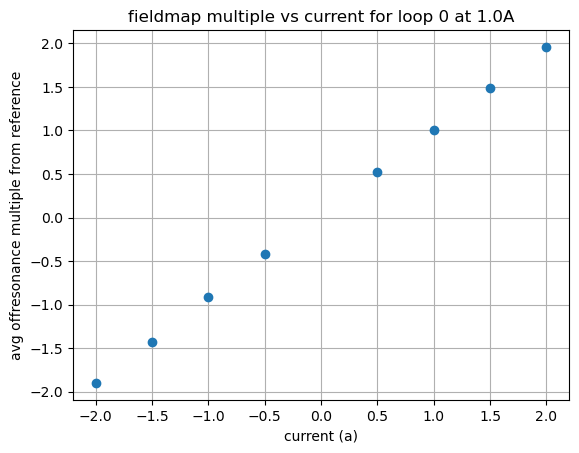

----------------------------------------
| * Acquiring fieldmap for Loop 1 with current -2.0|
----------------------------------------
15:03:34 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
15:03:34 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
15:04:00 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
15:04:00 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
15:04:27 SHIM TOOL: Done. 2 scans completed!
15:04:27 SHIM TOOL: Initiating transfer using rsync.
15:04:28 SHIM TOOL: Initiating transfer using rsync.
15:04:29 SHIM TOOL: evaluating map 0
15:04:29 SHIM TOOL: finished setting the per slice stats for map 0
15:04:29 SHIM TOOL: finished setting the volume stats for map 0
15:04:29 SHIM TOOL: evaluating map 1
15:04:29 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
----------------------------------------
| * Acquiring fieldmap for Loop 1 with current -1.5|
----------------------

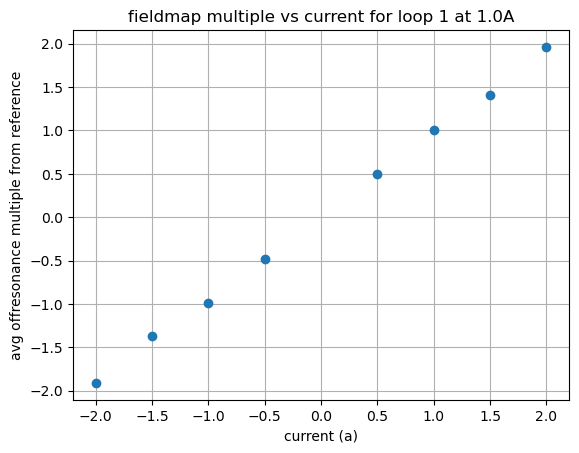

----------------------------------------
| * Acquiring fieldmap for Loop 2 with current -2.0|
----------------------------------------
15:11:07 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
15:11:07 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
15:11:34 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
15:11:34 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
15:12:02 SHIM TOOL: Done. 2 scans completed!
15:12:02 SHIM TOOL: Initiating transfer using rsync.
15:12:02 SHIM TOOL: Initiating transfer using rsync.
15:12:03 SHIM TOOL: evaluating map 0
15:12:03 SHIM TOOL: finished setting the per slice stats for map 0
15:12:03 SHIM TOOL: finished setting the volume stats for map 0
15:12:03 SHIM TOOL: evaluating map 1
15:12:03 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
----------------------------------------
| * Acquiring fieldmap for Loop 2 with current -1.5|
----------------------

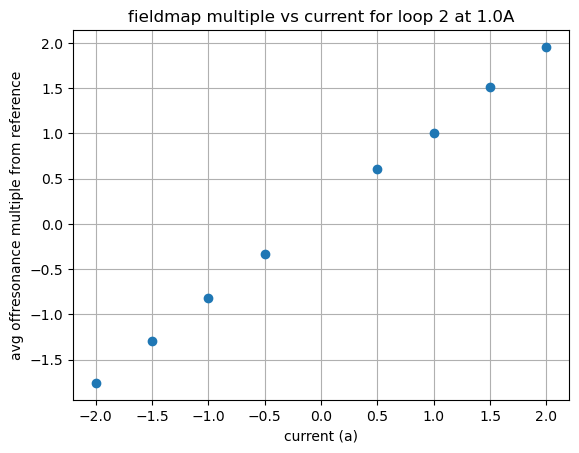

----------------------------------------
| * Acquiring fieldmap for Loop 3 with current -2.0|
----------------------------------------
15:18:44 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
15:18:44 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
15:19:12 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
15:19:12 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
15:19:39 SHIM TOOL: Done. 2 scans completed!
15:19:39 SHIM TOOL: Initiating transfer using rsync.
15:19:40 SHIM TOOL: Initiating transfer using rsync.
15:19:40 SHIM TOOL: evaluating map 0
15:19:40 SHIM TOOL: finished setting the per slice stats for map 0
15:19:40 SHIM TOOL: finished setting the volume stats for map 0
15:19:40 SHIM TOOL: evaluating map 1
15:19:40 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
----------------------------------------
| * Acquiring fieldmap for Loop 3 with current -1.5|
----------------------

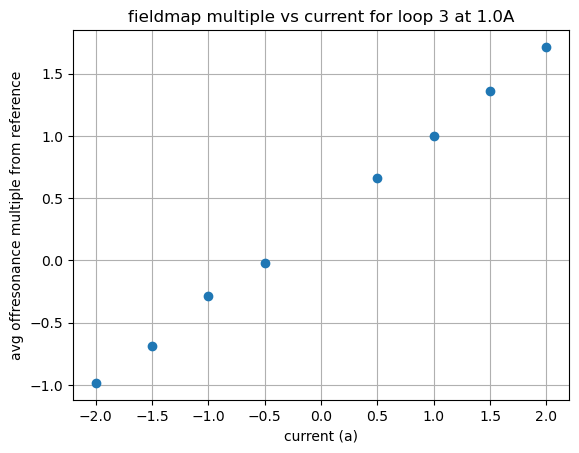

In [6]:
# currents = [-2.0, -1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
currents = [-2.0, -1.5, -1.0, -0.5, 0.5, 1.0, 1.5, 2.0]
referenceIdx = 5
fieldmapss = []
for loopIdx in range(4):
    fieldmaps = acquireCoil(tool, loopIdx, currents, background)
    referenceCurrent = currents[referenceIdx]
    fieldmapss.append(fieldmaps)
    reference = fieldmaps[referenceIdx]
    plotDivAvgsOfReference(reference, referenceCurrent, fieldmaps, currents, loopIdx)

In [7]:
for fieldmaps in fieldmapss:
    fieldmaps = np.stack(fieldmaps, axis=0)
fieldmaps_0_4 = np.stack(fieldmapss, axis=0)
print(fieldmaps_0_4.shape)

(4, 8, 60, 64, 64)


In [10]:
os.mkdir('data')
np.save('data/fieldmaps_0_4.npy', fieldmaps_0_4)
np.save('data/currents_0_4.npy', currents)

nanstds of the divided fieldmaps: [152.56943674616076, 165.501901417477, 135.89022838618627, 150.00267788288133, 150.00267788288133, 150.77823832019178, 189.42935622478686, 249.02127835582453] for currents: [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]


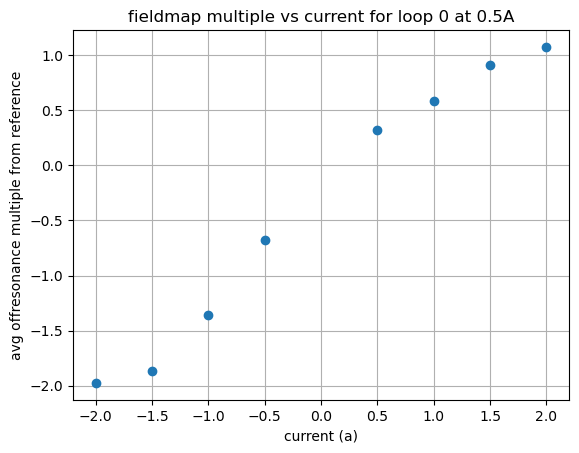

nanstds of the divided fieldmaps: [26.4043178253964, 16.053793007978612, 10.082330560511535, 8.356734158554913, 8.356734158554913, 5.162365132369426, 4.01988753563182, 9.19468385224265] for currents: [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]


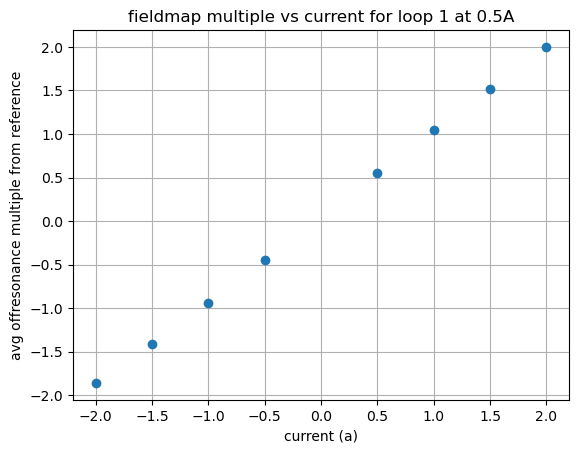

nanstds of the divided fieldmaps: [14.941581612509188, 15.492007947502502, 31.07894059259277, 29.84929755708779, 29.84929755708779, 30.35082354248069, 20.426865608449024, 18.374400867309465] for currents: [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]


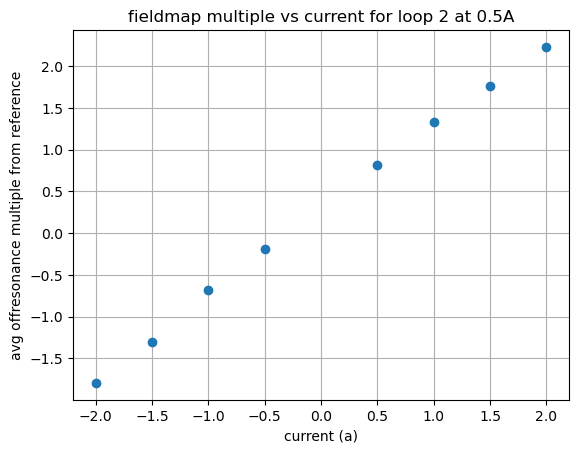

nanstds of the divided fieldmaps: [40.68686331794444, 34.483168908849564, 41.26231542197399, 47.86192836221453, 47.86192836221453, 53.76370389713341, 67.06045298119332, 72.94946248753745] for currents: [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]


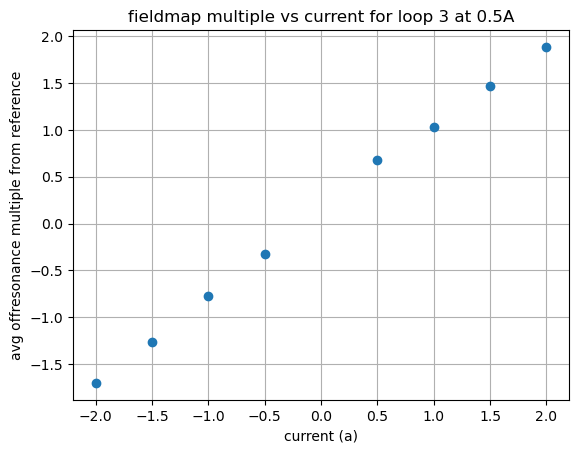

In [12]:
loadedFieldmapss = np.load("data/fieldmaps_0_4.npy")
loadedCurrents = np.load("data/currents_0_4.npy")
referenceIdx = 4
for loopIdx, fieldmaps in enumerate(loadedFieldmapss):
    reference = fieldmaps[referenceIdx] - fieldmaps[referenceIdx-1]
    plotDivAvgsOfReference(reference, loadedCurrents[referenceIdx], fieldmaps, loadedCurrents, loopIdx)

# Play with the data that we got

In [ ]:
data = np.load('fieldmapDataCorrect.npz')
references, fieldmapss, currents, background  = data['references'], data['fieldmapss'], data['currents'], data['background']
referenceCurrent = 1.0
# print statistics on all the loaded cells...
print("loaded data")
for loopIdx in range(8):
    plotDivAvgsOfReference(references[loopIdx], referenceCurrent, fieldmapss[loopIdx], currents, loopIdx)

In [ ]:
currentsCopy = currents.copy()
newRefIndex = -4
newReferenceCurrent = currents[newRefIndex]
print(f"new reference index: {newRefIndex}, current: {newReferenceCurrent}")
# remove the new reference from the list
currentsCopy = np.concatenate((currentsCopy[:newRefIndex],currentsCopy[newRefIndex+1:]))
currentsCopy = np.append(currentsCopy, referenceCurrent)
for i in range(8):
    fieldmaps = fieldmapss[i].copy()
    reference = references[i].copy()
    newReference, fieldmaps = fieldmaps[newRefIndex], np.concatenate((fieldmaps[:newRefIndex],fieldmaps[newRefIndex+1:]))
    fieldmaps = np.append(fieldmaps, reference)
    plotDivAvgsOfReference(newReference, newReferenceCurrent, fieldmaps, currentsCopy, i)


# time to do it again

In [ ]:
currents = [-2.0, 1.0]
referenceIdx = 1
fieldmapss = []
for loopIdx in range(8):
    fieldmaps = acquireCoil(tool, loopIdx, currents, background)
    referenceCurrent = currents[referenceIdx]
    fieldmapss.append(fieldmaps)
    reference = fieldmaps[referenceIdx]
    plotDivAvgsOfReference(reference, referenceCurrent, fieldmaps, currents, loopIdx)